In [19]:
import numpy as np
import random

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
LOWER_BOUND = -1
UPPER_BOUND = 1

# Import data

In [21]:
DATA_FOLDER = "competition-data/"
DATA_TEST = "test.csv"
DATA_TRAIN = "train.csv"

In [22]:
from proj1_helpers import load_csv_data
y_train, x_train, ids_train = load_csv_data(DATA_FOLDER + DATA_TRAIN, LOWER_BOUND, UPPER_BOUND)
y_test, x_test, ids_test = load_csv_data(DATA_FOLDER + DATA_TEST, LOWER_BOUND, UPPER_BOUND)

In [23]:
x_train

array([[ 138.47 ,   51.655,   97.827, ...,    1.24 ,   -2.475,  113.497],
       [ 160.937,   68.768,  103.235, ...,      nan,      nan,   46.226],
       [     nan,  162.172,  125.953, ...,      nan,      nan,   44.251],
       ..., 
       [ 105.457,   60.526,   75.839, ...,      nan,      nan,   41.992],
       [  94.951,   19.362,   68.812, ...,      nan,      nan,    0.   ],
       [     nan,   72.756,   70.831, ...,      nan,      nan,    0.   ]])

In [24]:
tx_train = x_train.T
tx_test = x_test.T

# Cleaning data

In [25]:
"""# constants
CATEGORICAL_FIELDS = ['PRI_jet_num']

for c in CATEGORICAL_FIELDS:
    median_rep_data_train[c] = categorical_rep_data(train_data[c])
    median_rep_data_test[c] = categorical_rep_data(test_data[c])"""

"# constants\nCATEGORICAL_FIELDS = ['PRI_jet_num']\n\nfor c in CATEGORICAL_FIELDS:\n    median_rep_data_train[c] = categorical_rep_data(train_data[c])\n    median_rep_data_test[c] = categorical_rep_data(test_data[c])"

In [26]:
from implementations import *
tx_train = delete_features(tx_train, 0.9)
tx_train.shape

(30, 250000)

In [27]:
tx_train = replace_nan_by_median(tx_train)
tx_test = replace_nan_by_median(tx_test)

In [28]:
#tx_train = min_max(tx_train)

In [29]:
mean_train, std_train, tx_train = standardize(tx_train)
_ , _ , tx_test = standardize(tx_test)

In [11]:
tx_train, y_train = balance(tx_train.T, y_train, LOWER_BOUND, UPPER_BOUND)

# Logistic Regression

In [12]:
tx_train.shape
#y_train.shape

(30, 171334)

In [133]:
w_lq, loss_lq = least_squares(y_train, tx_train)
w_lq

array([[  1.22272262e-02],
       [ -2.53066585e-01],
       [ -2.63456197e-01],
       [  1.29243444e-02],
       [  1.92805217e-02],
       [  1.04114628e-01],
       [  7.14391045e-03],
       [  2.80223055e-01],
       [ -2.77613511e-02],
       [ -3.20636860e+02],
       [ -1.87675501e-01],
       [  1.20153160e-01],
       [  7.45926200e-02],
       [  6.22912124e+01],
       [ -8.00284480e-04],
       [ -8.11540982e-04],
       [  6.14322549e+01],
       [ -6.52146153e-04],
       [  2.55788788e-03],
       [  1.00389486e-01],
       [  9.43326598e-04],
       [ -4.78438671e-02],
       [  5.46733536e-02],
       [ -3.73249553e-02],
       [  5.84626499e-04],
       [  2.49121185e-04],
       [ -1.82119810e-02],
       [  1.51617615e-03],
       [ -1.61520971e-03],
       [  2.71568882e+02]])

# Cross Validation

Widget Javascript not detected.  It may not be installed or enabled properly.


D:  30 N:  187500
D:  30 N:  187500
D:  30 N:  187500
D:  30 N:  187500

0.671952
[[ 0.01182765]
 [-0.25521394]
 [-0.2619219 ]
 [ 0.01215252]
 [ 0.02273516]
 [ 0.09867168]
 [ 0.00454805]
 [ 0.28112265]
 [-0.02805849]
 [ 0.03470048]
 [-0.18813786]
 [ 0.11875323]
 [ 0.07343079]
 [ 0.17560814]
 [ 0.00091612]
 [-0.00049536]
 [ 0.27957327]
 [-0.00223749]
 [ 0.00319966]
 [ 0.1028472 ]
 [ 0.0012875 ]
 [-0.04965038]
 [ 0.04900965]
 [-0.04130171]
 [ 0.00121271]
 [ 0.00228446]
 [-0.02113161]
 [ 0.00113255]
 [-0.00196027]
 [-0.06182037]]


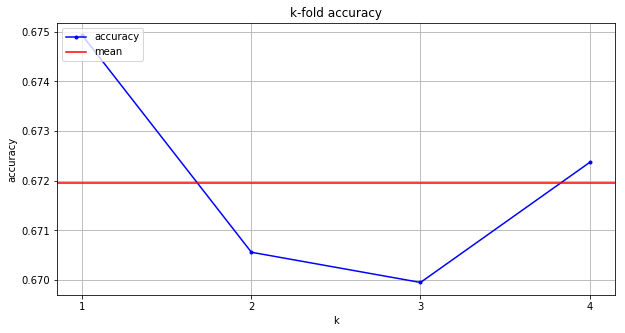

In [40]:
from implementations import build_k_indices
from tqdm import tqdm_notebook
from matplotlib.pyplot import figure, show
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

def cross_validation_demo():
    seed = 3
    k_fold = 4
    #lambdas = np.logspace(-3, 1, 10)
    initial_w = init_w(tx_train)
    max_iters = 300
    gamma = 0.7
    k_indices = build_k_indices(y_train, k_fold, seed)
    results = []
    #for lambda_ in tqdm_notebook(lambdas):
    lambda_= 0.00001
    accs = []
    for k in tqdm_notebook(range(k_fold)):
        w_tr, acc = cross_validation(y_train, tx_train.T, initial_w,
                                     max_iters,  k_indices, k, gamma, lambda_, LOWER_BOUND, UPPER_BOUND)
        accs.append(acc)
    acc_mean = np.mean(accs)
    results.append(acc_mean)
    print(acc_mean)
    print(w_tr)
    
    fig = plt.subplots(1, 1, figsize=(10,5))
    plt.plot(range(1,k_fold+1), accs, marker=".", color='b', label='accuracy')
    plt.axhline(y=acc_mean, color='r', label='mean')
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel("k")
    plt.ylabel("accuracy")
    plt.title("k-fold accuracy")
    plt.legend(loc=2)
    plt.grid(True)
    plt.show()

cross_validation_demo()

# Predict labels

In [101]:
from proj1_helpers import predict_labels_kaggle

In [134]:
y_pred = predict_labels_kaggle(w_lq, tx_test.T, LOWER_BOUND, UPPER_BOUND)

# Submission

In [122]:
from proj1_helpers import create_csv_submission

In [135]:
create_csv_submission(ids_test, y_pred, "test8.csv")

Test n : algorithm / features / y / w
- - - - - - - - - - - - - - - - - - - 
Test 1 : least_squares / all features standardized / y = -1,1 / random init_w

Test 2 : least_squares / corr > 0.1 features standardized / y = -1,1 / random init_w

Test 3 : least_squares_GD(10000,0.5) / all features standardized / y = -1,1 / random init_w

Test 4 : least_squares_GD(10000,0.5) / all features standardized / y = -1,1 / random init_w / poly, degree=1

Test 5 : least_squares / all features standardized / y = -1,1 / random init_w / median + categorical

Test 6 : logistic_regressoin  /all features standardized / y = 0,1 / random init_w / median + categorical + balanced

Test 7 : least_squares / all features standardized / y = 0,1 / random init_w

Test 8 : Test 1

## Further work

- balance output (batch numpy)
- median and category
- features engineering : features d'intéraction
- logistic regression 